In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'fraud-detection:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F817870%2F1399887%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240914%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240914T153947Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D268a9bf46846f3cf37ea6ae7520e39c35ce43cfb128e11ddf0a63897652359d73b1d504bdab1b7eb6e488de2495005894d419772e55bde7b91625e6ae8a207127558394a234b4f437cab0c652f7ea4616a405dc9566c6990d2411844fd6208231f2889c11762dc3f685c5920123cbe0d34f60deec0e7306a96fae95be0441f2a06aba6f96ab51c5708dedfa005756ee20ac613ce4392cf88fd50402ec97c7e9896c2343786fa1c07037b42b31250c52822616c1295426c2b3ef62f5f1e12dbe4b7e396e92560b21e8f9d25aaa6aa2e4db880d54c03c68cf0ae1cf431035b7e9a499712942f321e90b51aab83b45ef9cfd83d1f5d919d42bf067e86fe9f01f0bb'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 211766662 bytes downloaded
Downloaded and uncompressed: fraud-detection
Data source import complete.


In [4]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/fraud-detection/fraudTrain.csv
/kaggle/input/fraud-detection/fraudTest.csv


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
import plotly.express as px
sns.set(rc = {'figure.figsize':(15,8)})
df=pd.read_csv('../input/fraud-detection/fraudTrain.csv')
df.isna().sum()

,0
Unnamed: 0,0
trans_date_trans_time,0
cc_num,0
merchant,0
category,0
amt,0
first,0
last,0
gender,0
street,0


In [6]:
df.drop_duplicates(inplace=True)

## 1. Transaction amount vs Fraud

With the dataset cleaned, we can now start to examine how various features relate to fraud. First we will see how the distrition of transaction amount differs between fraudulent and normal activities. As there are extreme outliers in transaction amount, and the 99 percentile is around \\$546, we subset the data for any transaction amounts below \\$1,000 to make the visualizations more readable.

In [5]:
df['amt'].describe()

,amt
count,1.296675e+06
mean,7.035104e+01
std,1.603160e+02
min,1.000000e+00
25%,9.650000e+00
50%,4.752000e+01
75%,8.314000e+01
max,2.894890e+04


In [7]:
np.percentile(df['amt'],99)

545.9926000000002

#2. Amount vs Fraud

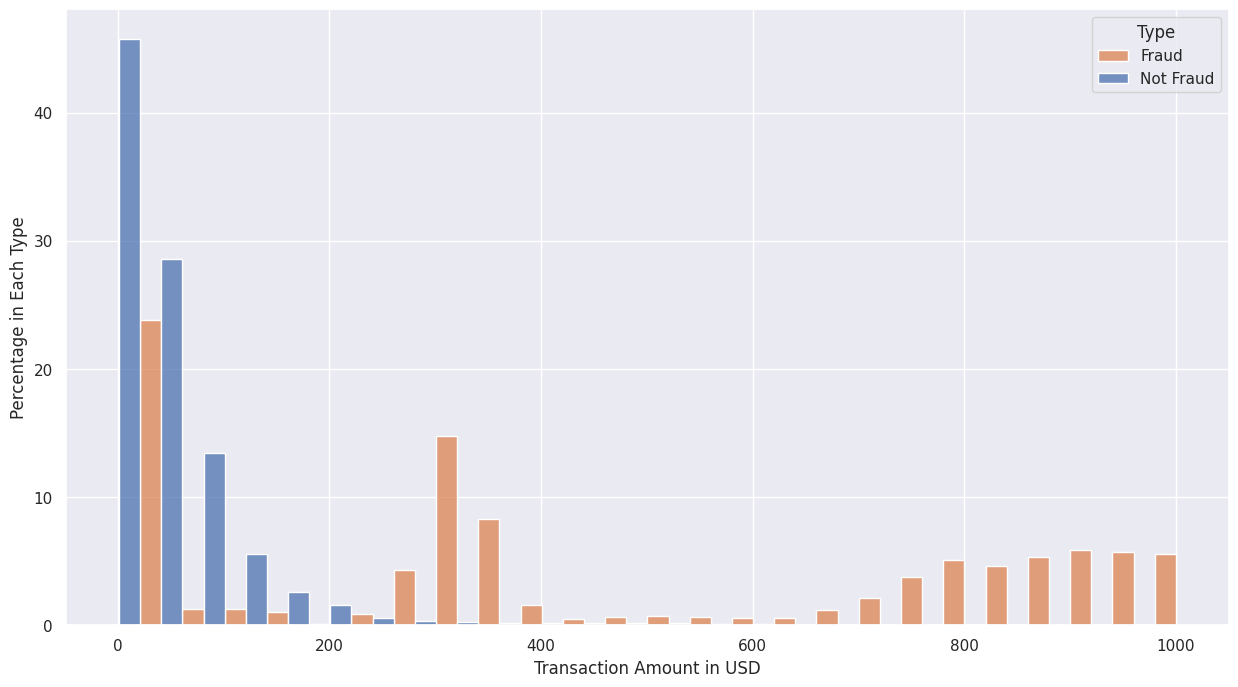

In [8]:
#amount vs fraud
ax=sns.histplot(x='amt',data=df[df.amt<=1000],hue='is_fraud',stat='percent',multiple='dodge',common_norm=False,bins=25)
ax.set_ylabel('Percentage in Each Type')
ax.set_xlabel('Transaction Amount in USD')
plt.legend(title='Type', labels=['Fraud', 'Not Fraud'])

The result is very interesting! While normal transactions tend to be around \\$200 or less, we see fraudulent transactions peak around \\$300 and then at the \$800-\\$1000 range. There is a very clear pattern here!

## 2. Gender vs Fraud
Second, we will examine whether one gender is more susceptible to fraud than the other.

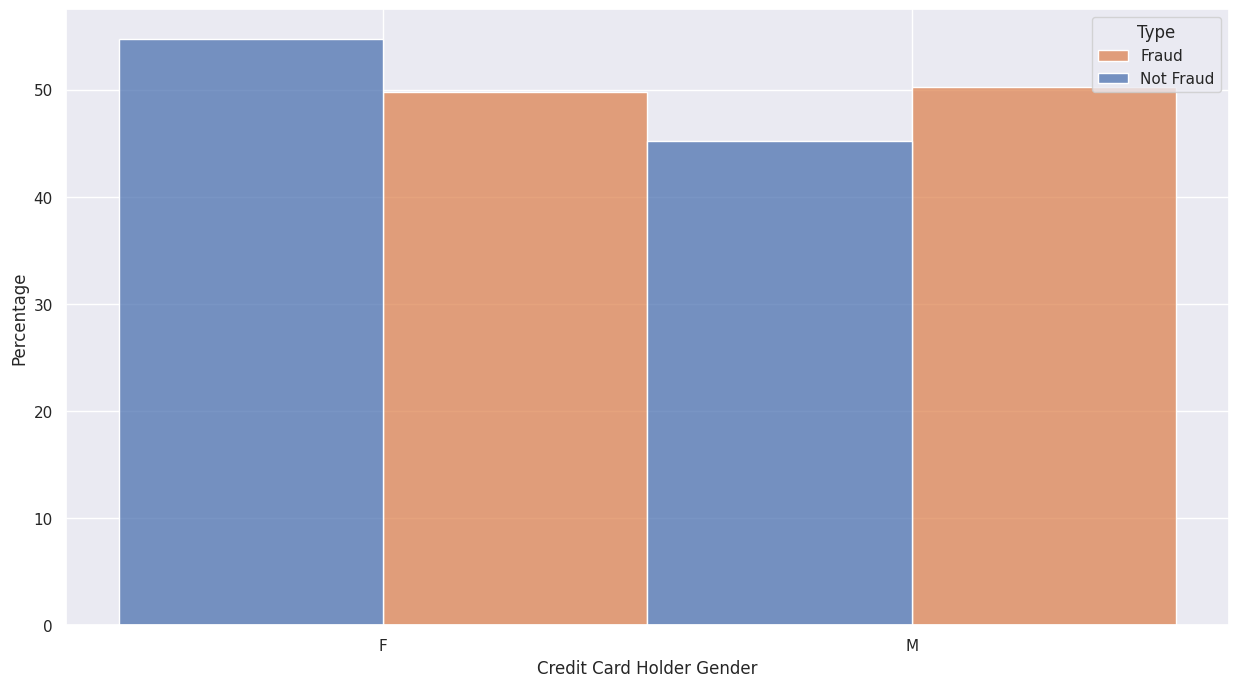

In [9]:
#Gender vs Fraud
ax=sns.histplot(x='gender',data=df, hue='is_fraud',stat='percent',multiple='dodge',common_norm=False)
ax.set_ylabel('Percentage')
ax.set_xlabel('Credit Card Holder Gender')
plt.legend(title='Type', labels=['Fraud', 'Not Fraud'])

In this case, we do not see a clear difference between both genders. Data seem to suggest that females and males are almost equally susceptible (50%) to transaction fraud. Gender is not very indicative of a fraudulent transaction.

## 3. Spending Category vs Fraud
Third, we examine in which spending categories fraud happens most predominantly.

Text(0.5, 1.0, 'The Percentage Difference of Fraudulent over Non-Fraudulent Transations in Each Spending Category ')

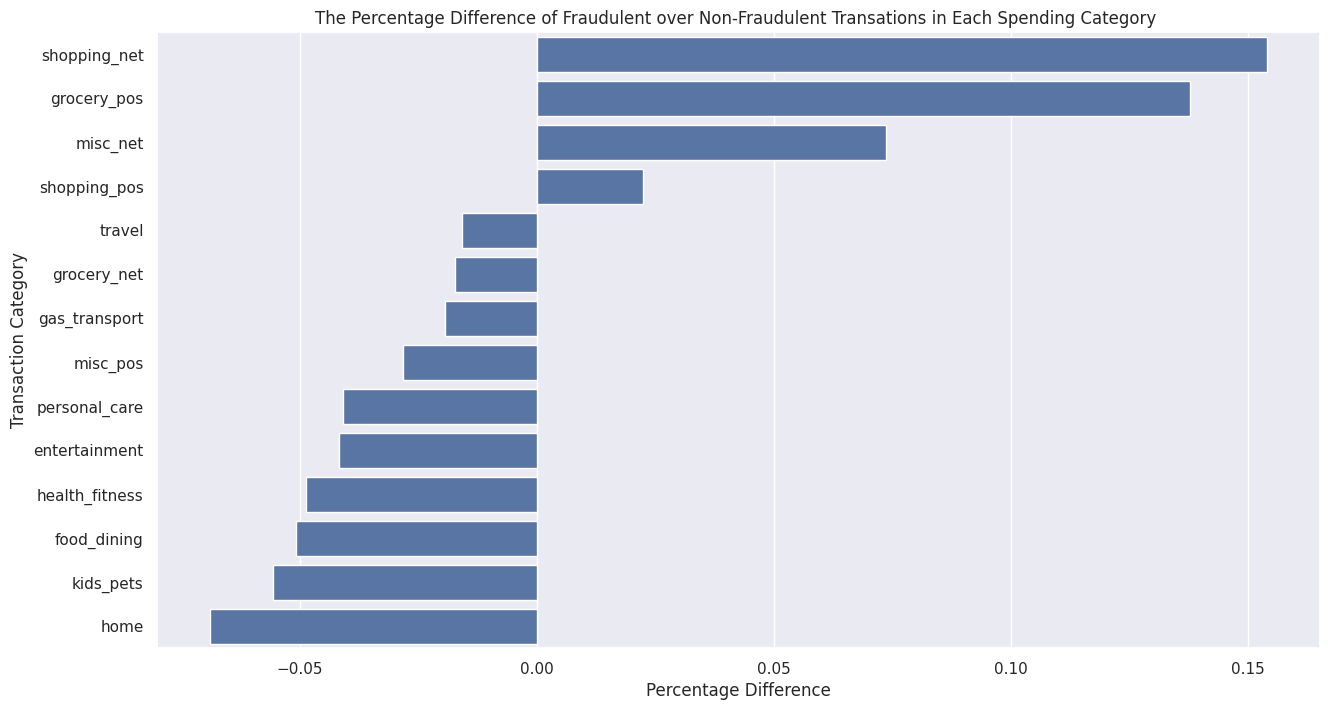

In [10]:
#calculate the percentage difference
a=df[df['is_fraud']==0]['category'].value_counts(normalize=True).to_frame().reset_index()
a.columns=['category','not fraud percentage']

b=df[df['is_fraud']==1]['category'].value_counts(normalize=True).to_frame().reset_index()
b.columns=['category','fraud percentage']
ab=a.merge(b,on='category')
ab['diff']=ab['fraud percentage']-ab['not fraud percentage']

ax=sns.barplot(y='category',x='diff',data=ab.sort_values('diff',ascending=False))
ax.set_xlabel('Percentage Difference')
ax.set_ylabel('Transaction Category')
plt.title('The Percentage Difference of Fraudulent over Non-Fraudulent Transations in Each Spending Category ')

Some spending categories indeed see more fraud than others! Fraud tends to happen more often in 'Shopping_net', 'Grocery_pos', and 'misc_net' while 'home' and 'kids_pets' among others tend to see more normal transactions than fraudulent ones.

## 4. Age vs Fraud
Are older people more prone to credit card fraud? Or is it the other way around? Given the birthday info, we can calculate the age of each card owner (in 2022) and see whether a trend exists.

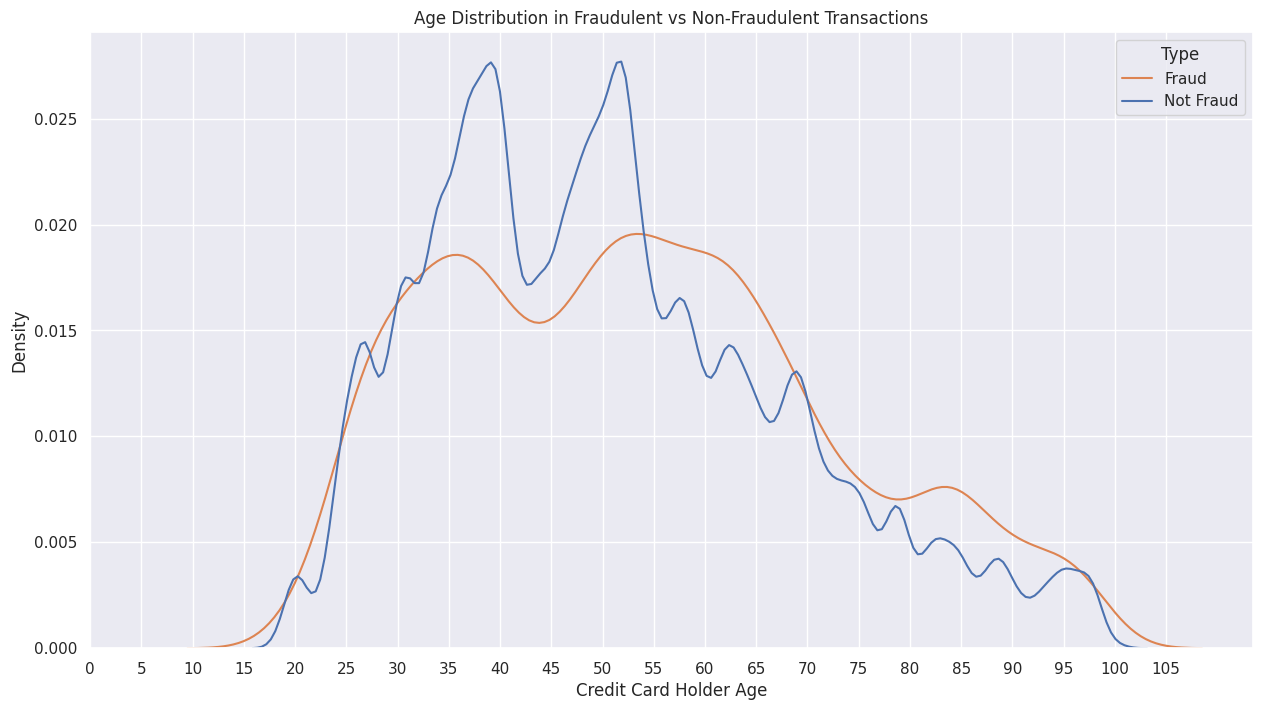

In [11]:
#age vs fraud
import datetime as dt
df['age']=dt.date.today().year-pd.to_datetime(df['dob']).dt.year
ax=sns.kdeplot(x='age',data=df, hue='is_fraud', common_norm=False)
ax.set_xlabel('Credit Card Holder Age')
ax.set_ylabel('Density')
plt.xticks(np.arange(0,110,5))
plt.title('Age Distribution in Fraudulent vs Non-Fraudulent Transactions')
plt.legend(title='Type', labels=['Fraud', 'Not Fraud'])

The age distribution is visibly different between 2 transaction types. In normal transactions, there are 2 peaks at the age of 37-38 and 49-50, while in fraudulent transactions, the age distribution is a little smoother and the second peak does include a wider age group from 50-65. This does suggest that older people are potentially more prone to fraud.

## 5. Cyclicality of Credit Card Fraud

How do fraudulent transactions distribute on the temporal spectrum? Is there an hourly, monthly, or seasonal trend? We can use the transaction time column to answer this question.

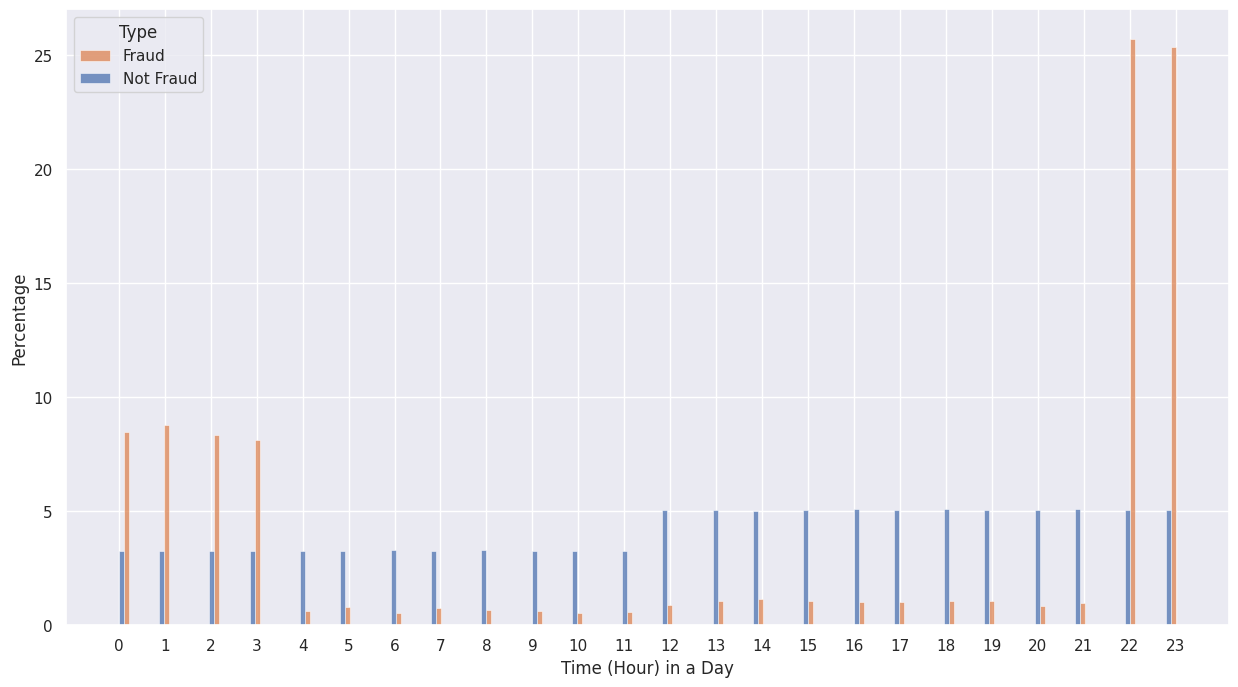

In [12]:
#time in a day vs fraud
df['hour']=pd.to_datetime(df['trans_date_trans_time']).dt.hour
ax=sns.histplot(data=df, x="hour", hue="is_fraud", common_norm=False,stat='percent',multiple='dodge')
ax.set_ylabel('Percentage')
ax.set_xlabel('Time (Hour) in a Day')
plt.xticks(np.arange(0,24,1))
plt.legend(title='Type', labels=['Fraud', 'Not Fraud'])

<ipython-input-13-3a23f5cd44ab>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['',"Mon","Tue","Wed","Thu","Fri","Sat","Sun"])


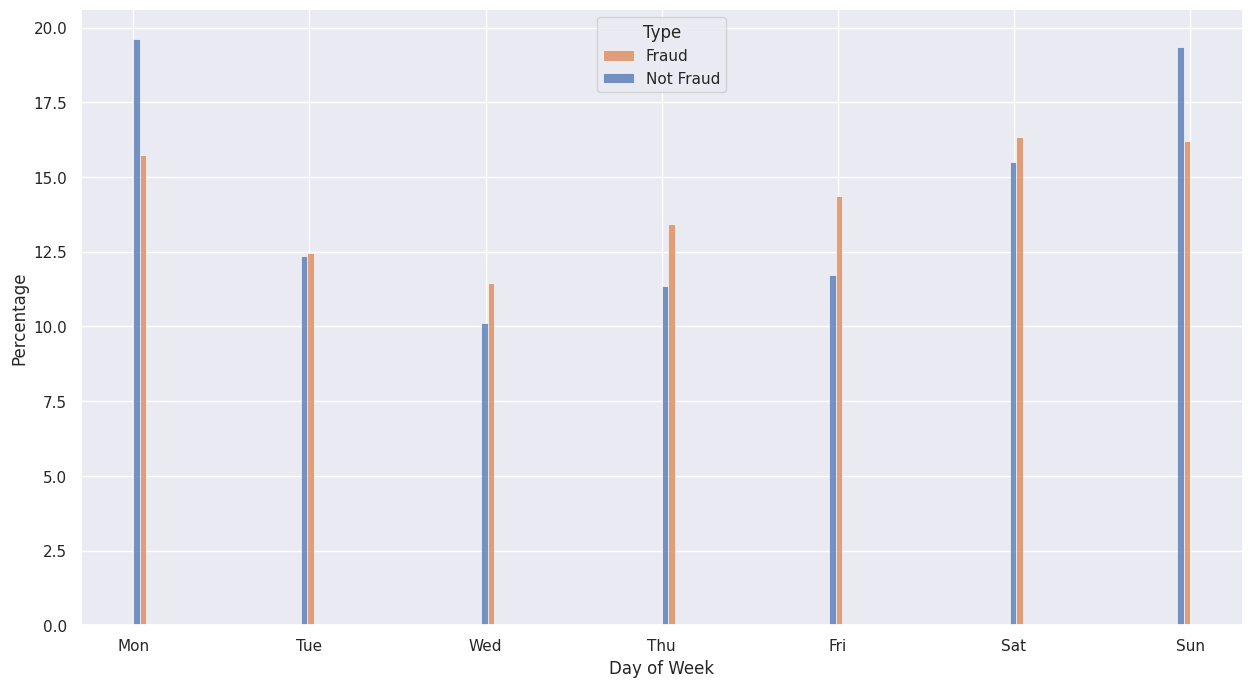

In [13]:
#day of week vs fraud
df['day']=pd.to_datetime(df['trans_date_trans_time']).dt.dayofweek
ax=sns.histplot(data=df, x="day", hue="is_fraud", common_norm=False,stat='percent',multiple='dodge')
ax.set_xticklabels(['',"Mon","Tue","Wed","Thu","Fri","Sat","Sun"])
ax.set_ylabel('Percentage')
ax.set_xlabel('Day of Week')
plt.legend(title='Type', labels=['Fraud', 'Not Fraud'])

Normal transactions tend to happen more often on Monday and Sunday while fraudulent ones tend to spread out more evenly throughout the week.

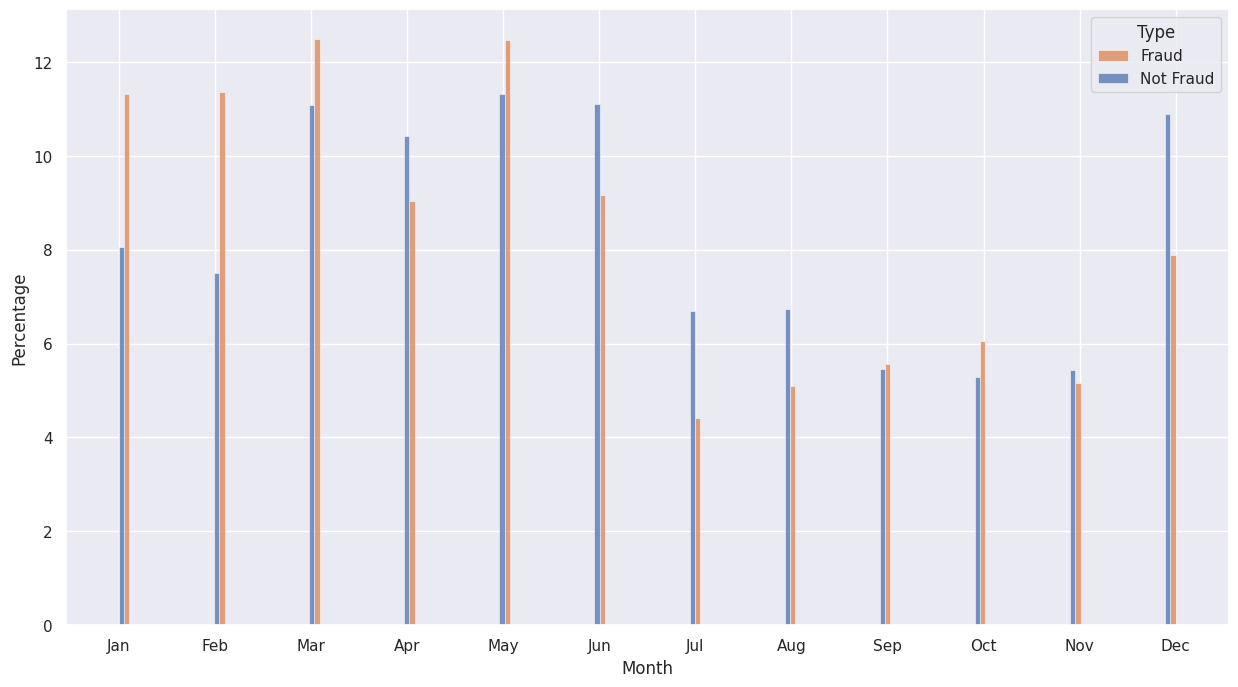

In [14]:
#month vs fraud
df['month']=pd.to_datetime(df['trans_date_trans_time']).dt.month
ax=sns.histplot(data=df, x="month", hue="is_fraud", common_norm=False,stat='percent',multiple='dodge')
ax.set_ylabel('Percentage')
ax.set_xlabel('Month')
plt.xticks(np.arange(1,13,1))
ax.set_xticklabels(["Jan","Feb","Mar","Apr","May","Jun","Jul",'Aug','Sep','Oct','Nov','Dec'])
plt.legend(title='Type', labels=['Fraud', 'Not Fraud'])

Very interesting results! While normal payments peak around December (Christmas), and then late spring to early summer, fraudulent transactions are more concentrated in Jan-May. There is a clear seasonal trend.

## 6. State vs Fraud
Now that we have examined fraud on the temporal level, let's also explore which geographies are more prone to fraud. We will use the same methodology as in Part 3, where we calculate the difference in geographical distribution between the 2 transaction types.

Text(0.5, 1.0, 'The Percentage of Fraudulent over Non-Fraudulent Transcations in Each State')

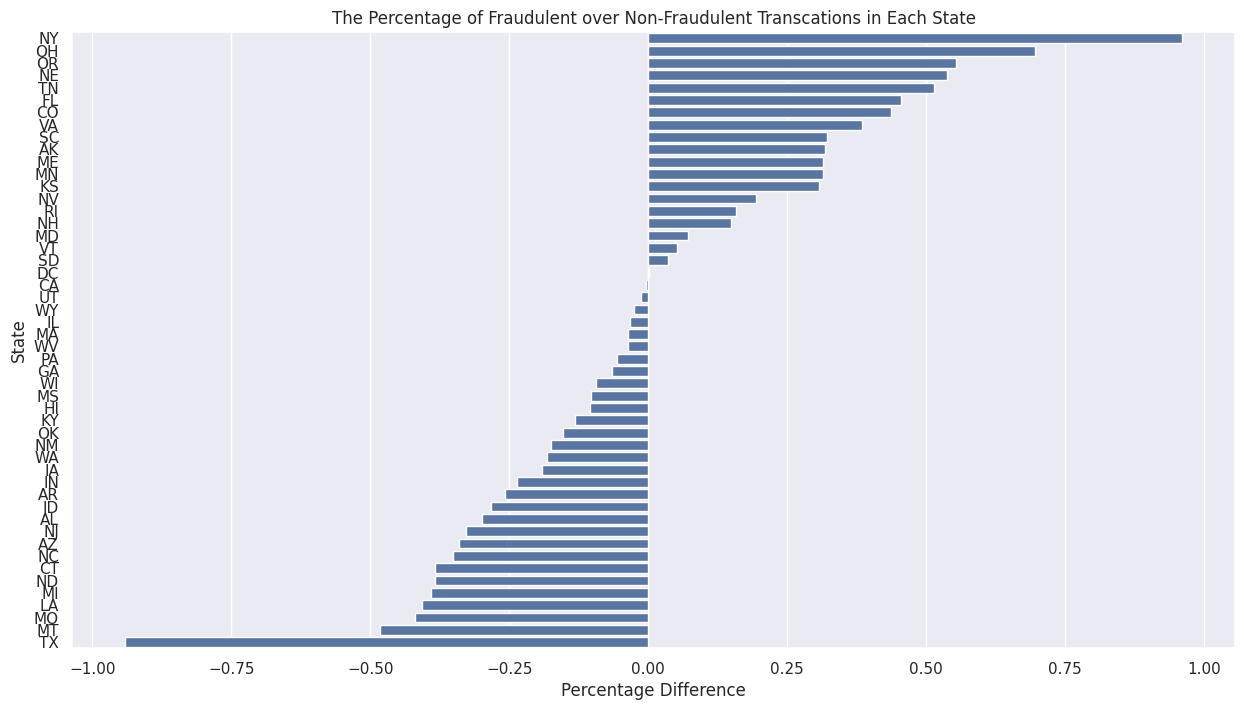

In [15]:
a=df['state'][df.is_fraud==0].value_counts(normalize=True)
a=a.to_frame()
a=a.reset_index()
a.columns = ['State', 'Per']

b=df['state'][df.is_fraud==1].value_counts(normalize=True)
b=b.to_frame()
b=b.reset_index()
b.columns = ['State', 'Per']
merged=a.merge(b,on='State')
merged['diff']=merged['Per_y']-merged['Per_x']
merged['diff']=merged['diff']*100
merged=merged.sort_values('diff',ascending=False)

ax1=sns.barplot(data=merged, x='diff',y='State')
ax1.set_xlabel('Percentage Difference')
ax1.set_ylabel('State')
plt.title('The Percentage of Fraudulent over Non-Fraudulent Transcations in Each State')

As can be seen, NY and OH among others have a higher percentage of fraudulent transactions than normal ones, while TX and MT are the opposite. However, it should be pointed out that the percentage differences in those states are not very significant but a correlation does exist.

In [16]:
#subset the training data to include only the features that we need
train=df[['category','amt','zip','lat','long','city_pop','merch_lat','merch_long','age','hour','day','month','is_fraud']]
#convert category to dummy variables
train=pd.get_dummies(train, drop_first=True)
y_train=train['is_fraud'].values
X_train=train.drop("is_fraud", axis='columns').values

In [17]:
#let's do the same to the testing dataset
test=pd.read_csv('../input/fraud-detection/fraudTest.csv')
test['age']=dt.date.today().year-pd.to_datetime(test['dob']).dt.year
test['hour']=pd.to_datetime(test['trans_date_trans_time']).dt.hour
test['day']=pd.to_datetime(test['trans_date_trans_time']).dt.dayofweek
test['month']=pd.to_datetime(test['trans_date_trans_time']).dt.month
test=test[['category','amt','zip','lat','long','city_pop','merch_lat','merch_long','age','hour','day','month','is_fraud']]
#convert category to dummy variables
test=pd.get_dummies(test, drop_first=True)
y_test=test['is_fraud'].values
X_test=test.drop("is_fraud", axis='columns').values

In [18]:
#logistic regression
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

method= SMOTE()
X_resampled, y_resampled = method.fit_resample(X_train, y_train)
model=LogisticRegression()
model.fit(X_resampled,y_resampled)
predicted=model.predict(X_test)
print('Classification report:\n', classification_report(y_test, predicted))
conf_mat = confusion_matrix(y_true=y_test, y_pred=predicted)
print('Confusion matrix:\n', conf_mat)
print('Share of Non-Fraud in Test Data:', 1-round(y_test.sum()/len(y_test),4))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification report:
               precision    recall  f1-score   support

           0       1.00      0.95      0.98    553574
           1       0.06      0.75      0.11      2145

    accuracy                           0.95    555719
   macro avg       0.53      0.85      0.54    555719
weighted avg       1.00      0.95      0.97    555719

Confusion matrix:
 [[527940  25634]
 [   542   1603]]
Share of Non-Fraud in Test Data: 0.9961


In [19]:
#random forest
from sklearn.ensemble import RandomForestClassifier
model2 = RandomForestClassifier(random_state=5)
model2.fit(X_resampled,y_resampled)
predicted=model2.predict(X_test)
print('Classification report:\n', classification_report(y_test, predicted))
conf_mat = confusion_matrix(y_true=y_test, y_pred=predicted)
print('Confusion matrix:\n', conf_mat)
print('Share of Non-Fraud in Test Data:', 1-round(y_test.sum()/len(y_test),4))

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.88      0.73      0.80      2145

    accuracy                           1.00    555719
   macro avg       0.94      0.86      0.90    555719
weighted avg       1.00      1.00      1.00    555719

Confusion matrix:
 [[553362    212]
 [   580   1565]]
Share of Non-Fraud in Test Data: 0.9961


The above metrics show that although the Random Forest model has a slightly lower recall, it has much better accuracy and precision! Although still in need of improvements, it serves as a way better basis than the Logistic Regression model above for future deployment.